# Εργασία στην Εφαρμοσμένη Επιστήμη Δεδομένων
**Μαρία Μπουμπή p3210135**

## A1

Το σχήμα του DataFrame έχει ως εξής:
- decision_id: Αριθμός απόφασης 
- year: Έτος απόφασης 
- department_type: Τύπος τμήματος ("Ποινικό" ή "Πολιτικό")
- department_number: Αριθμός τμήματος
- judges: Ονόματα δικαστών
- intro_text: Κείμενο από "ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ"
- legal_reasoning: Τμήμα από "ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ"
- decision_basis: Τμήμα από "ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ"
- articles_pk: Αρθρα ΠΚ
- articles_kpd: Αρθρα ΚΠΔ
- articles_ak: Αρθρα ΑΚ
- articles_kpold: Αρθρα ΚΠολΔ
- url: Url αποφασεις


## A2


In [1]:
# Ιmporting necessary libraries

import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import pprint
import numpy as np
import unicodedata
import time
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import ast


In [2]:
# Cleans the input text by removing line breaks and extra whitespace.
# Useful for standardizing the extracted content from court decisions,
# making it easier to process and store in the DataFrame.

def normalize_text(text):
    if not text:
        return None
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

**Σημείωση:** Για την εξασφάλιση συνέπειας στα κείμενα των αποφάσεων που συλλέχθηκαν, χρησιμοποιήθηκε η συνάρτηση remove_accents. Η ανάγκη αυτή προέκυψε καθώς παρατηρήθηκε ότι σε ορισμένα σημεία του κειμένου οι χαρακτήρες εμφανίζονταν με τόνους, ενώ σε άλλα χωρίς. Η αφαίρεση των τονισμών επέτρεψε την ομογενοποίηση των δεδομένων, διευκολύνοντας την περαιτέρω ανάλυση και αναζήτηση συγκεκριμένων όρων ή φράσεων.

In [3]:
# Removes accents from characters in the input text

def remove_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text)
                   if unicodedata.category(c) != 'Mn')


In [4]:
# Function to extract the case number from the text.

def extract_articles(text):
    # Normalize the text by removing accents and converting to lowercase
    normal_text = remove_accents(text).lower()

    # Define Greek variations of the word "article" in different forms
    article_prefix = r'(?:αρθ(?:ρα|ρο|ρου|ρ|ρ\.|ρ\.|ρων|\.)?|αρ\.?)'

    # Define regex patterns for different codes
    code_pattern = r"(?:Π\.?Κ|Κ\.?Π\.?Δ|Κ\.?Ποιν\.?Δ|Κ\.?Πολ\.?Δ|Α\.?Κ|[Ππ]οινικου\s+[Κκ]ωδικα|[Κκ]ωδικα\s+[Ππ]οινικης\s+[Δδ]ικονομιας|[Κκ]ωδικα\s+[Αα]στικου\s+[Κκ]ωδικα|[Κκ]ωδικα\s+[Ππ]ολιτικης\s+[Δδ]ικονομιας)"

    # Define regex pattern for articles
    article_pattern = re.compile(rf"""
    (?:
        {article_prefix}\s+                                  
        (?P<list>[\d+\s,καιη(παρ|§)\.\-]+)
        \s*(?:του)?\s*
        \s*(?:νεου|ν\.|ιδιου|ισχυοντος)?(?:\s*\d{{1,2}}[/.-]\d{{1,2}}[/.-]\d{{2,4}})?\s*                    
        (?P<code>{code_pattern}) 
    )
    |

    (?:{article_prefix}\s*
    (?P<num1>\d+[Α-Ωα-ω]*)
    (?:\s*(παρ|§)\.?\s*\d+(?:-\d+)?\s*[α-ωΑ-Ω]?[`΄’']?[,]?)?\s*
    (?:του)?\s*
    \s*(?:νεου|ν\.|ιδιου|ισχυοντος)?(?:\s*\d{{1,2}}[/.-]\d{{1,2}}[/.-]\d{{2,4}})?\s*
    (?P<code1>{code_pattern})
    )
    |

    (?P<code3>{code_pattern})\s*
    (?P<num2>\d+[Α-Ωα-ω]*)
    (?:\s*(?P<par2>(?:παρ|§|παραγραφος)\.?\s*\d+)\s*[α-ωΑ-Ω]?[`΄’']?[,]?)? 
    |

    (?:{article_prefix}\s*
    (?P<num3>\d+)
    (?P<qualifiers>
        (?:
            \s*(?:αρ\.?|αριθ\.?|αριθμ\.?|αριθμος|παρ\.?|§|παραγραφο)\s*\d+(?:\s*(?:η|και)\s*\d+)*
        )?
        (?:
            \s*(?:εδ|εδαφ|εδαφιο|περ|στοιχ|παρ)[\.,]?\s*[α-ωΑ-Ω0-9]+[`΄’']?[,]?
        )?
    )?
    \s*(?:του)?\s*
    \s*(?:νεου|ν\.|ιδιου|ισχυοντος)?(?:\s*\d{{1,2}}[/.-]\d{{1,2}}[/.-]\d{{2,4}})?\s*
    (?P<code4>{code_pattern})
    )

    """, re.IGNORECASE | re.VERBOSE)

    articles_pk, articles_kpd, articles_ak, articles_kpold = [], [], [], []

    # Find all matches in the normalized text and extract relevant information using regex groups
    for match in article_pattern.finditer(normal_text):
        # Extract the legal code (e.g., ΠΚ, ΚΠΔ, etc.)
        code = (match.group("code") or match.group("code1") or 
                match.group("code3") or match.group("code4"))
        if not code:
            continue

        # Normalize the legal code to standard abbreviations
        code = code.upper().replace(".", "")
        code = code.replace("ΚΩΔΙΚΑ ΠΟΛΙΤΙΚΗΣ ΔΙΚΟΝΟΜΙΑΣ", "ΚΠΟΛΔ").replace(
            "ΠΟΙΝΙΚΟΥ ΚΩΔΙΚΑ", "ΠΚ").replace(
            "ΚΩΔΙΚΑ ΠΟΙΝΙΚΗΣ ΔΙΚΟΝΟΜΙΑΣ", "ΚΠΔ").replace(
            "ΚΩΔΙΚΑ ΑΣΤΙΚΟΥ ΚΩΔΙΚΑ", "ΑΚ").replace("ΚΠΟΙΝΔ", "ΚΠΔ")

        article_nums = []
        if match.group("list"):
            # Handle multiple article numbers listed together (e.g., "άρθρα 224, 334 και 144")
            raw_list = match.group("list")
            raw_list = re.sub(r'\s*(?:και|η|,|-)\s*', ',', raw_list)
            parts = [part.strip() for part in raw_list.split(',') if part.strip()]
            for part in parts:
                m = re.match(r"(\d+[Α-Ωα-ω]*)(?:\s*παρ\.?\s*(\d+))?", part)
                if m:
                    num = m.group(1)
                    int_num = num.replace(" ", "")
                    if int_num.isdigit() and int(int_num) < 10:
                        continue # Skip very low article numbers which are often false positives
                    par = m.group(2)
                    article_nums.append(f"{num} παρ.{par}" if par else num)
        elif match.group("num1"):
            num = match.group("num1").replace(" ", "")
            if num.isdigit() and int(num) < 10:
                continue # Skip very low article numbers which are often false positives
            article_nums = [num]

        elif match.group("num2"):
            num = match.group("num2").replace(" ", "")
            if num.isdigit() and int(num) < 10:
                continue # Skip very low article numbers which are often false positives
            par = match.group("par2")
            article_nums = [f"{num} {par}" if par else num]

        elif match.group("num3"):
            num = match.group("num3").replace(" ", "")
            if num.isdigit() and int(num) < 10:
                continue # Skip very low article numbers which are often false positives
            qualifiers = match.group("qualifiers") or ""
            full_ref = f"{num} {qualifiers.strip()}" if qualifiers else num
            article_nums = [re.sub(r'\s+', ' ', full_ref.strip())]


        # Assign each article to the appropriate code list
        for num in article_nums:
            cleaned = f"{num.strip()} {code}"
            if code == "ΠΚ":
                articles_pk.append(cleaned)
            elif code =="ΚΠΔ":
                articles_kpd.append(cleaned)
            elif code == "ΑΚ":
                articles_ak.append(cleaned)
            elif code == "ΚΠΟΛΔ":
                articles_kpold.append(cleaned)

    return {
        'articles_pk': list(set(articles_pk)) or np.nan,
        'articles_kpd': list(set(articles_kpd)) or np.nan,
        'articles_ak': list(set(articles_ak)) or np.nan,
        'articles_kpold': list(set(articles_kpold)) or np.nan,
    }


In [5]:
# Extracts the judges from the text of a court decision.

def extract_judges(text):
    # Normalizing the text to remove accents and convert to lowercase
    normalized_text = remove_accents(text).lower()
    pattern = r"συγκροτηθηκε.*?απο τους δικαστες\s*[:|,]\s*(.*?)(συνηλθε|παρεσταθηκαν|συνεδριασε)"
    match = re.search(pattern, normalized_text, flags=re.DOTALL)

    if not match:
        return []

    judges_raw = match.group(1).strip()

    # Removal of text within parentheses
    judges_no_parens = re.sub(r"\(.*?\)", "", judges_raw)

    # Removal of specific phrases and titles
    judges_cleaned = (
        judges_no_parens.replace("αντιπροεδρο του αρειου παγου", "")
                        .replace("αντιπροεδρος του αρειου παγου", "")
                        .replace("αντιπροεδρου του αρειου παγου", "")
                        .replace("αντιπροεδρους", "")
                        .replace("αρεοπαγιτης", "")
                        .replace("προεδρος του αρειου παγου", "")
                        .replace("προεδρο του αρειου παγου", "")
                        .replace("προεδρευοντα αρεοπαγιτη", "")
                        .replace("προεδρος", "")
                        .replace("εισηγητρια", "")
                        .replace("εισηγητης", "")
                        .replace("εισηγητη", "")
                        .replace("αρεοπαγιτες", "")
                        .replace("αρεοπαγιτης", "")
                        .replace(".", "")
                        .strip()
    )

    # Splitting the cleaned judges string into individual judges
    parts = re.split(r",\s*", judges_cleaned)
    final_judges = []
    for part in parts:
        if "και" in part and len(part.split("και")) == 2:
            final_judges.extend([n.strip() for n in part.split("και")])
        else:
            final_judges.append(part.strip())

    return [j for j in final_judges if j]


**Σημείωση:** Σε πολλές περιπτώσεις κατά την εξαγωγή των αποφάσεων παρατηρήθηκε η παρουσία λατινικών χαρακτήρων στη θέση ελληνικών, λόγω λαθών κατά την πληκτρολόγηση. Για την αποκατάσταση της σωστής γραφής και την ενίσχυση της συνέπειας στο κείμενο, υλοποιήθηκε η συνάρτηση fix_latin_letters, η οποία αντικαθιστά λατινικούς χαρακτήρες που μοιάζουν οπτικά με τους αντίστοιχους ελληνικούς (π.χ. "A" → "Α", "N" → "Ν", "o" → "ο") . 

In [6]:
# Replaces visually similar Latin characters with their correct Greek equivalents.
def fix_latin_letters(text):
    latin_to_greek = {
        'A': 'Α', 'B': 'Β', 'E': 'Ε', 'Z': 'Ζ', 'H': 'Η', 'I': 'Ι',
        'K': 'Κ', 'M': 'Μ', 'N': 'Ν', 'O': 'Ο', 'P': 'Ρ', 'T': 'Τ',
        'Y': 'Υ', 'X': 'Χ', 'a': 'α', 'b': 'β', 'e': 'ε', 'z': 'ζ',
        'h': 'η', 'i': 'ι', 'k': 'κ', 'm': 'μ', 'n': 'ν', 'o': 'ο',
        'p': 'ρ', 't': 'τ', 'y': 'υ', 'x': 'χ'
    }
    return ''.join(latin_to_greek.get(c, c) for c in text)


**Σημειωση:** Για τη συλλογή των αποφάσεων του Αρείου Πάγου για το έτος 2024, ανέλυσα το POST αίτημα που αποστέλλεται από την επίσημη ιστοσελίδα κατά την αναζήτηση αποφάσεων μέσω της φόρμας. Από εκεί προέκυψαν οι παράμετροι του payload, όπως X_TMHMA, X_SUB_TMHMA, X_TELESTIS_ETOS, και x_ETOS, οι οποίες επιλέγουν τις αποφάσεις βάσει έτους και τμήματος.

Το σύνολο των αποφάσεων για το 2024 ήταν 2575. Ωστόσο, ανάμεσα σε αυτές υπήρχαν 8 αποφάσεις του Νόμου 3068/2002 και 2 αποφάσεις των Πράξεων Νόμου (4842/2021), οι οποίες δεν εμπίπτουν στις Ποινικές ή Πολιτικές υποθέσεις και δεν σχετίζονται με το αντικείμενο της εργασίας. Συνεπώς, ο τελικός αριθμός αποφάσεων που συλλέχθηκαν είναι 2.465.

In [7]:
# Session with retry strategy for robustness in case of server errors
session = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount("https://", HTTPAdapter(max_retries=retries))
headers = {"User-Agent": "Mozilla/5.0"}

# Prepare request to search for decisions from year 2024
base_url = "https://www.areiospagos.gr/nomologia/"
search_url = base_url + "apofaseis_result.asp?S=1"
payload = {
    "X_TMHMA": "6",
    "X_SUB_TMHMA": "1",
    "X_TELESTIS_ETOS": "1",
    "x_ETOS": "2024",
    "submit_krit": "Αναζήτηση"
}

# Send POST request to search page
response = session.post(search_url, headers=headers, data=payload, timeout=10)
response.encoding = 'windows-1253'
soup = BeautifulSoup(response.text, 'html.parser')

# Collect only decision links related to ΠΟΙΝΙΚΕΣ (Criminal) and ΠΟΛΙΤΙΚΕΣ (Civil) cases
decision_links = []
for a in soup.find_all('a', href=True, class_='blue10_cursor'):
    href = a['href']
    full_url = base_url + href
    if "apofaseis_DISPLAY.asp" in href:
        if "ΠΟΙΝΙΚΕΣ" in href or "ΠΟΛΙΤΙΚΕΣ" in href:
            decision_links.append(full_url)
        else:
            continue
# --- End of filtering ---

print(f" Total filtered decision links: {len(decision_links)}")

# Scrape each decision link and extract relevant data
data_list = []
for i, url in enumerate(decision_links):
    print(f"🔎 [{i+1}/{len(decision_links)}] Processing: {url}")
    
    try:
        time.sleep(2) # To avoid overwhelming the server with requests
        res = session.get(url, headers=headers, timeout=10)
        res.encoding = 'windows-1253'
        soup = BeautifulSoup(res.text, 'html.parser')
        text = soup.get_text(separator='\n')

        # Extracting decision ID and year (e.g. "Απόφαση 123/2024")
        decision_id_match = re.search(r"Απόφαση\s+(\d+)\s*/\s*(\d{4})", text)
        decision_id = f"{decision_id_match.group(1)}/{decision_id_match.group(2)}" if decision_id_match else None
        year = decision_id_match.group(2) if decision_id_match else None

        # Extract department number and type from parentheses (e.g. "(B2, Ποινικό)")
        dept_match = re.search(r"\(([^,]+),\s*(.*?)\)", text)
        department_number, department_type = dept_match.groups() if dept_match else (None, None)

        # Normalize text by correcting Latin letters and cleaning spacing
        text = fix_latin_letters(text)
        text = normalize_text(text)

        # Extract names of judges
        judges = extract_judges(text)

        # Extract articles using the regex function
        articles = extract_articles(text)

        # Extract the introduction section that typically begins with "ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ"
        match = re.search(r"(ΤΟ\s+ΔΙΚΑΣΤΗ\s*ΡΙΟ\s+ΤΟΥ\s+ΑΡΕΙΟΥ\s+ΠΑΓΟΥ.*?)(?=ΣΚΕΦΘΗΚΕ|ΣΚΕΦΤΗΚΕ)", text, re.DOTALL)
        intro_text = normalize_text(match.group(1)) if match else None

        # Extract the legal reasoning section starting with "ΣΚΕΦΘΗΚΕ" and ending before the final ruling
        reasoning_match = re.search(r"(ΣΚΕΦΘΗΚΕ|ΣΚΕΦΤΗΚΕ).*?(ΓΙΑ\s*ΤΟΥ[Σ]*\s*ΛΟΓΟΥΣ\s*(ΑΥΤΟΥΣ\s*)?)", text, re.DOTALL)
        legal_reasoning = reasoning_match.group(0).replace("ΓΙΑ (ΤΟΥΣ|ΤΟΥ) ΛΟΓΟΥΣ ΑΥΤΟΥΣ", "").strip() if reasoning_match else None

        # Normalize again by removing any remaining diacritics
        text = unicodedata.normalize("NFKD", text)
        text = ''.join(c for c in text if not unicodedata.combining(c))

        # Extract the decision basis (justification) that typically follows "ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ"
        basis_match = re.search(
            r"ΓΙΑ\s*ΤΟΥ[Σ]*\s*ΛΟΓΟΥΣ\s*(ΑΥΤΟΥΣ\s*)?(.*?)(ΚΡΙΘΗΚΕ|Κριθηκε|Κριθηκε, αποφασιστηκε και δημοσιευθηκε)",
            text,
            re.DOTALL | re.IGNORECASE
        )

        if basis_match:
            basis_text = basis_match.group(2).strip()
        else:
            basis_text = None


        data_list.append({
            "decision_id": decision_id,
            "year": year,
            "department_type": department_type,
            "department_number": department_number,
            "judges": judges,
            "intro_text": intro_text,
            "legal_reasoning": legal_reasoning,
            "decision_basis": basis_text,
            "articles_pk": articles['articles_pk'],
            "articles_kpd": articles['articles_kpd'],
            "articles_ak": articles['articles_ak'],
            "articles_kpold": articles['articles_kpold'],
            "url": url
        })


    except Exception as e:
        print(f" Error at {url}: {e}")
        continue

# Create DataFrame
df = pd.DataFrame(data_list)
print(" Done! Total decisions scraped:", len(df))

# Save to CSV
df.to_csv("court_decisions_2024.csv", index=False, encoding='utf-8-sig')


 Total filtered decision links: 2465
🔎 [1/2465] Processing: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=RWKDTA2X1554EH8YXW0M7NFLRRV23P&apof=11_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
🔎 [2/2465] Processing: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=N1RABGMSWJWJ7DHP4GZ8JI6Q4TFTMD&apof=12_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
🔎 [3/2465] Processing: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=RSMY30KIH82MLOOC1VPLFAXXXSO0UO&apof=13_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
🔎 [4/2465] Processing: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=ZU5LE0TC6T0315OGAQ6IMDLESK4ST3&apof=14_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
🔎 [5/2465] Processing: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=RMR33L8SVVS7NNHF953HQAIZ6BH2BY&apof=31_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
🔎 [6/2465] Processing: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=ZMKMKEWUEMJDUCD7H9BL57XHERNGA1&apof=32_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
🔎 [7/2465] Processing: https://www.areiospagos.gr/nomologia/apo

### Check for none values.

**Σημείωση:** Κατά τη διαδικασία συλλογής δεδομένων παρατηρήθηκαν περιπτώσεις όπου οι ιστοσελίδες των αποφάσεων επέστρεφαν HTTP Error 404.19 (Not Found). Ως αποτέλεσμα, όλες οι πληροφορίες που έπρεπε να εξαχθούν (π.χ. decision_id, judges, articles, κ.λπ.) ήταν NaN, με μοναδική διαθέσιμη τιμή το url. Οι συγκεκριμένες εγγραφές εντοπίστηκαν και αφαιρέθηκαν από το τελικό dataset, καθώς δεν περιείχαν χρήσιμα δεδομένα για ανάλυση.

In [9]:
df = pd.read_csv('court_decisions_2024.csv')
# Check for missing decision_id values
rows_with_missing_id = df[df['decision_id'].isna()]

print("🚫 Αποφάσεις με κενό decision_id:")

for idx, row in rows_with_missing_id.iterrows():
    url = row['url']
    null_columns = row[row.isnull()].index.tolist()
    null_fields = ', '.join(null_columns)
    print(f"URL: {url}")
    print(f" Missing Fields: {null_fields}")
    print("-" * 50)

# Remove decisions with empty decision_id
df_removed = df[~df['decision_id'].isna()].reset_index(drop=True)
print("✅ Αποφάσεις με κενό decision_id έχουν αφαιρεθεί.")
print("Αριθμος αποφάσεων μετα την αφαιρεση:", len(df_removed))

🚫 Αποφάσεις με κενό decision_id:
URL: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=MB8Y2VCMD8HPT1WCL1B3H1C0Y3ZW8T&apof=597_2024&info=ΠΟΛΙΤΙΚΕΣ -  Δ
 Missing Fields: decision_id, year, department_type, department_number, intro_text, legal_reasoning, decision_basis, articles_pk, articles_kpd, articles_ak, articles_kpold
--------------------------------------------------
URL: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=ZG6H99V57W001A6LAWOCMD6IDIPA2M&apof=68_2024&info=ΠΟΛΙΤΙΚΕΣ -  Α2
 Missing Fields: decision_id, year, department_type, department_number, intro_text, legal_reasoning, decision_basis, articles_pk, articles_kpd, articles_ak, articles_kpold
--------------------------------------------------
URL: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=OE4CMD32UP87US3L5SPCGFERX0QHRS&apof=1186_2024&info=ΠΟΛΙΤΙΚΕΣ -  Α2
 Missing Fields: decision_id, year, department_type, department_number, intro_text, legal_reasoning, decision_basis, articl

**Σημείωση:** Πριν τον έλεγχο για απουσία τιμών, αφαιρέθηκαν όλες οι στήλες που σχετίζονται με νομικά άρθρα (articles_pk, articles_kpd, articles_ak, articles_kpold), ώστε να αποφευχθούν ψευδώς αρνητικά αποτελέσματα. Οι στήλες αυτές αναμένεται να είναι κενές ανάλογα με τον τύπο της απόφασης (π.χ. οι ποινικές δεν περιλαμβάνουν άρθρα ΑΚ/ΚΠολΔ και οι πολιτικές δεν περιλαμβάνουν ΠΚ/ΚΠΔ)

In [10]:
# Remove articles columns from the DataFrame
removed_colums = ["articles_pk", "articles_kpd", "articles_ak", "articles_kpold"]

df_without_articles = df_removed.drop(columns=removed_colums)


In [11]:
# Function to check if the judges field is empty or not
def is_empty_judges(value):
    try:
        if pd.isna(value):
            return True
        parsed = ast.literal_eval(value) if isinstance(value, str) else value
        return isinstance(parsed, list) and len(parsed) == 0
    except:
        return True

# Check for rows with NaN values or empty judges list
rows_with_nulls = df_without_articles[
    df_without_articles.isnull().any(axis=1) | df_without_articles['judges'].apply(is_empty_judges)
]

print("Αποφάσεις με πεδία που περιέχουν NaN τιμές:")

# Εκτύπωση πληροφοριών για κάθε σειρά
for idx, row in rows_with_nulls.iterrows():
    decision_id = row['decision_id']
    url = row['url']
    
    # Ποια πεδία είναι NaN
    null_columns = row[row.isnull()].index.tolist()

    # Προσθήκη 'judges' αν είναι άδεια ή μη έγκυρη
    if is_empty_judges(row['judges']) and 'judges' not in null_columns:
        null_columns.append('judges')

    null_fields = ', '.join(null_columns)
    
    print(f"ID: {decision_id} | URL: {url} ")
    print(f" Missing Fields: {null_fields}")
    print("-" * 50)


Αποφάσεις με πεδία που περιέχουν NaN τιμές:
ID: 631/2024 | URL: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=QXT5TT6BRVJWFUSWEGQSPPLSC3RDGF&apof=631_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β2 
 Missing Fields: intro_text, legal_reasoning, decision_basis, judges
--------------------------------------------------
ID: 557/2024 | URL: https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=GY3NA1G5E1M8KHRT5174FSHY59HZC3&apof=557_2024&info=ΠΟΙΝΙΚΕΣ -  Ζ 
 Missing Fields: intro_text
--------------------------------------------------


**Σημείωση:**
Κατά τη διαδικασία ελέγχου των εγγραφών για κενά πεδία, διαπιστώθηκε ότι η απόφαση με αριθμό 631/2024 δεν αποτελεί κανονική απόφαση του δικαστηρίου, αλλά ανακοίνωση διορθωτικού χαρακτήρα. Συγκεκριμένα, στην ιστοσελίδα του Αρείου Πάγου αναφέρεται:

"Εκ παραδρομής, καταχωρήθηκε στο ηλεκτρονικό σύστημα δύο φορές δημοσίευση της απόφασης του Β2' Πολιτικού Τμήματος του Αρείου Πάγου, με αριθμό υπόθεσης 1352/2019, που αφορά την από 01/04/2019 αίτηση της ανώνυμης εταιρείας με την επωνυμία ".... Α.Ε." κατά των Κ. Τ. και λοιπών (συνολικά 12), για αναίρεση της 50/2019 απόφασης του Μονομελούς Πρωτοδικείου Χαλκίδας. Ο αριθμός που ισχύει είναι ο 632/2024, ενώ ο αριθμός 631/2024 δεν ισχύει."

Για τον λόγο αυτό, τα πεδία intro_text, legal_reasoning, decision_basis και judges εμφανίζονται κενά στην εν λόγω εγγραφή, καθώς δεν υπάρχει ουσιαστικό περιεχόμενο απόφασης προς εξαγωγή. Συνεπώς, η εγγραφή 631/2024 αφαιρέθηκε από το τελικό dataframe.

In [12]:
# Εντοπισμός και διαγραφή της απόφασης 631/2024 (ανακοίνωση, όχι κανονική απόφαση)
df_removed = df_removed[df_removed['decision_id'] != '631/2024'].reset_index(drop=True)
df_without_articles = df_without_articles[df_without_articles['decision_id'] != '631/2024'].reset_index(drop=True)

print("Η απόφαση 631/2024 αφαιρέθηκε καθώς αποτελεί ανακοίνωση και όχι πλήρη δικαστική απόφαση.")
print("Αριθμος αποφάσεων μετα την αφαιρεση:", len(df_removed))


Η απόφαση 631/2024 αφαιρέθηκε καθώς αποτελεί ανακοίνωση και όχι πλήρη δικαστική απόφαση.
Αριθμος αποφάσεων μετα την αφαιρεση: 2459


**Σημείωση:** Στην απόφαση με αριθμό 557/2024 λείπει η φραση "ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ" και για αυτο η τιμή intro_text είναι κενή.

#### Check for decisions with both articles_pk and articles_kpd (case 1) or articles_ak and articles_kpold (case 2) are empty.

In [13]:
# filtering for ΠΟΛΙΤΙΚΕΣ decisions
politic = df_removed[df_removed['department_type'] == 'ΠΟΛΙΤΙΚΕΣ']

#check if both 'articles_ak' and 'articles_kpold' are NaN
politic_missing = politic[
    politic['articles_ak'].isna() & politic['articles_kpold'].isna()
]
pd.set_option('display.max_colwidth', None)

print(f"Αριθμός πολιτικών αποφάσεων με κενά άρθρα: {len(politic_missing)}")
print(politic_missing[['url']])




Αριθμός πολιτικών αποφάσεων με κενά άρθρα: 1
                                                                                                                                  url
1191  https://www.areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=0L0MVT49E9YD89MKAFET68TAW00DSZ&apof=908_2024&info=ΠΟΛΙΤΙΚΕΣ -  Α2


In [14]:
# filtering for ΠΟΙΝΙΚΕΣ decisions
politic = df[df['department_type'] == 'ΠΟΙΝΙΚΕΣ']

#check if both 'articles_pk' and 'articles_kpd' are NaN
politic_missing = politic[
    politic['articles_pk'].isna() & politic['articles_kpd'].isna()
]

print(f"Αριθμός πολιτικών αποφάσεων με κενά άρθρα: {len(politic_missing)}")
pprint.pprint(politic_missing[[ 'url']])




Αριθμός πολιτικών αποφάσεων με κενά άρθρα: 0
Empty DataFrame
Columns: [url]
Index: []


### Save the finally dataframe 

In [15]:
df_removed.to_csv("court_decisions_2024_cleaned.csv", index=False, encoding='utf-8-sig')
print("✅ Αποφάσεις αποθηκεύτηκαν στο court_decisions_2024_cleaned.csv")
print(f"Αριθμος αποφάσεων: {len(df_removed)}")

✅ Αποφάσεις αποθηκεύτηκαν στο court_decisions_2024_cleaned.csv
Αριθμος αποφάσεων: 2459


## A3

In [16]:
from datasets import load_dataset

#load the dataset from the Huggingface hub
dataset = load_dataset("DominusTea/GreekLegalSum", split="train")

# print the names of the columns in the dataset
print(dataset.column_names)


c:\Users\Maria\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['text', 'summary', 'case_category', 'case_tags', 'subset']


Η σύγκριση με το dataset GreekLegalSum δεν είναι ουσιαστικά εφικτή, καθώς τα δύο σύνολα δεδομένων διαφέρουν σημαντικά στον τρόπο δημιουργίας και στη δομή τους.
Το GreekLegalSum αποτελεί ένα ομοιογενές, επιμελημένο dataset με συγκεκριμένα πεδία όπως text, summary, case_category και case_tags, σχεδιασμένο για εφαρμογές μηχανικής μάθησης. Αντίθετα, τα δεδομένα που συλλέξαμε προέρχονται από αυτόματο scraping και περιέχουν διαφορετικές πληροφορίες (π.χ. αριθμός απόφασης, έτος, δικαστές, άρθρα), χωρίς κατηγοριοποίηση ή περιλήψεις.
Επομένως, λόγω της διαφορετικής φύσης, στόχευσης και ομοιογένειας των δεδομένων, δεν είναι δυνατή μια άμεση ή δίκαιη σύγκριση μεταξύ των δύο συνόλων.

## A4

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import re
import ast
import seaborn as sns

df = pd.read_csv("court_decisions_2024_cleaned.csv")

### Year

**Αιτιολόγιση:** Χρησιμοποιησα ραβδογραμμα για την άμεση οπτική διάκριση του έτους με δεδομένα. Η έντονη κορυφή στο 2024 (2459 αποφάσεις) δείχνει ότι μόνο το συγκεκριμένο έτος περιλαμβάνει δεδομένα, κάτι που συνάδει με την οδηγία της εργασίας (συλλογή αποφάσεων μόνο για το 2024).

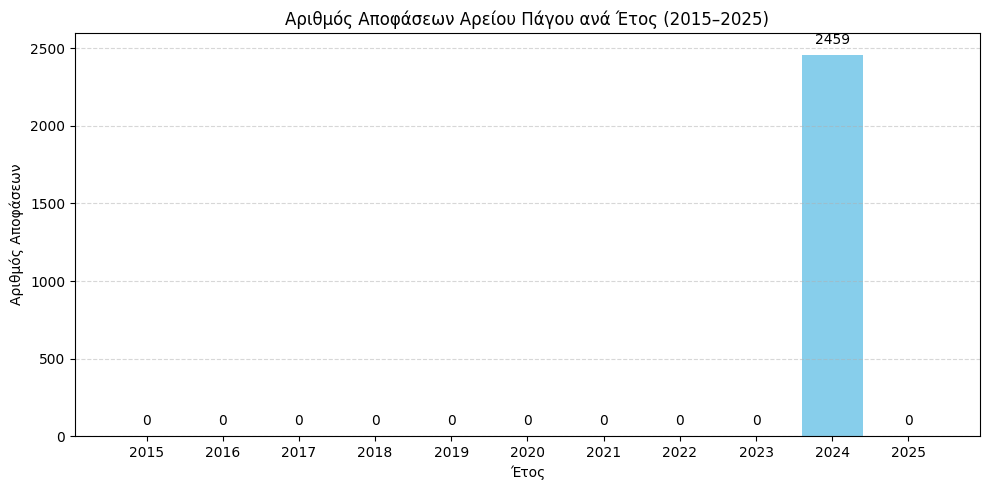

In [18]:
# create list of years from 2015 to 2025
years = list(range(2015, 2026))

# Count the number of decisions for each year
decision_counts = df['year'].value_counts().to_dict()

decision_counts_full = [decision_counts.get(year, 0) for year in years]
df_years = pd.DataFrame({'Έτος': years, 'Αποφάσεις': decision_counts_full})

# Plotting the number of decisions per year
plt.figure(figsize=(10, 5))
plt.bar(df_years['Έτος'], df_years['Αποφάσεις'], color='skyblue')
plt.title('Αριθμός Αποφάσεων Αρείου Πάγου ανά Έτος (2015–2025)')
plt.xlabel('Έτος')
plt.ylabel('Αριθμός Αποφάσεων')
plt.xticks(df_years['Έτος'])
plt.yticks(range(0, 2600, 500))
plt.ylim(0, 2600)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate the bars with the number of decisions
for index, value in enumerate(df_years['Αποφάσεις']):
    plt.text(df_years['Έτος'][index], value + 50, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



### Department_type

**Αιτιολόγιση:** Για την κατηγοριοποίηση των αποφάσεων ανά τύπο τμήματος χρησιμοποιείται ραβδόγραμμα (bar chart), το οποίο είναι κατάλληλο για σύγκριση συχνοτήτων μεταξύ διακριτών κατηγοριών, στην προκειμένη περίπτωση «ΠΟΛΙΤΙΚΕΣ» και «ΠΟΙΝΙΚΕΣ».

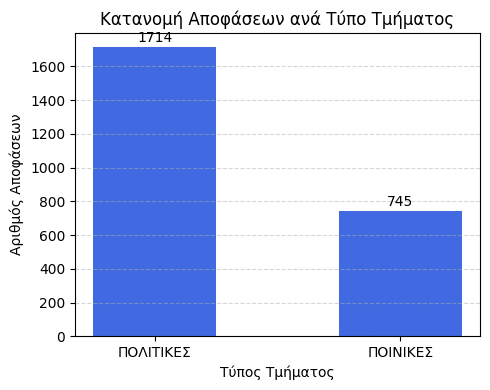

In [19]:
# count the number of decisions for each department type
type_counts = df['department_type'].value_counts()

# Plotting the distribution of decisions by department type
plt.figure(figsize=(5, 4))
plt.bar(type_counts.index, type_counts.values, color='royalblue', width=0.5)
plt.title('Κατανομή Αποφάσεων ανά Τύπο Τμήματος')
plt.xlabel('Τύπος Τμήματος')
plt.ylabel('Αριθμός Αποφάσεων')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate the bars with the number of decisions
for i, count in enumerate(type_counts.values):
    plt.text(i, count + 30, str(count), ha='center')

plt.tight_layout()
plt.show()


### Department_number

**Αιτιολόγιση:** Για την απεικόνιση του πλήθους αποφάσεων ανά συγκεκριμένο τμήμα του Αρείου Πάγου χρησιμοποιείται ξανά ραβδόγραμμα που αναδεικνύει την πλήθος των κατηγοριων μέσα σε κάθε τύπο τμήματος. Η χρήση ετικετών (με τον αριθμό των αποφάσεων πάνω στις ράβδους) ενισχύει περαιτέρω την αναγνωσιμότητα.

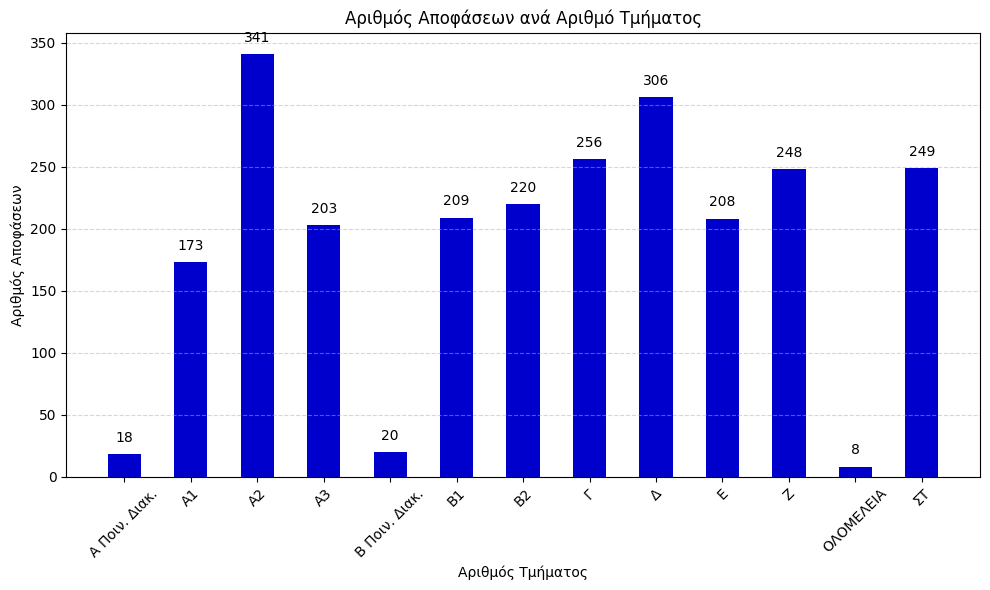

In [20]:
# Υπολογισμός αριθμού αποφάσεων ανά αριθμό τμήματος
dept_num_counts = df['department_number'].value_counts().sort_index()

# Σχεδίαση bar plot
plt.figure(figsize=(10, 6))
plt.bar(dept_num_counts.index, dept_num_counts.values, color='mediumblue', width=0.5)
plt.title('Αριθμός Αποφάσεων ανά Αριθμό Τμήματος')
plt.xlabel('Αριθμός Τμήματος')
plt.ylabel('Αριθμός Αποφάσεων')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Προσθήκη τιμών πάνω από τις μπάρες
for i, val in enumerate(dept_num_counts.values):
    plt.text(i, val + 10, str(val), ha='center')

plt.tight_layout()
plt.show()


### Judges


**Αιτιολόγιση:** Αυτό το διάγραμμα δημιουργήθηκε για να αναδείξει ποιοι δικαστές είχαν τη μεγαλύτερη συμμετοχή σε αποφάσεις κατά τη χρονική περίοδο που μελετήθηκε. Το ραβδογραμμα βοηθάει στην σύγκριση της συχνότητας εμφάνισης των δικαστών στις αποφάσεις και στον εντοπίσμό εκείνων με τη μεγαλύτερη δικαστική δραστηριότητα. Ενώ η χρήση του Seaborn συντελεί στην βελτίωση του αισθητικού αποτελέσματος.

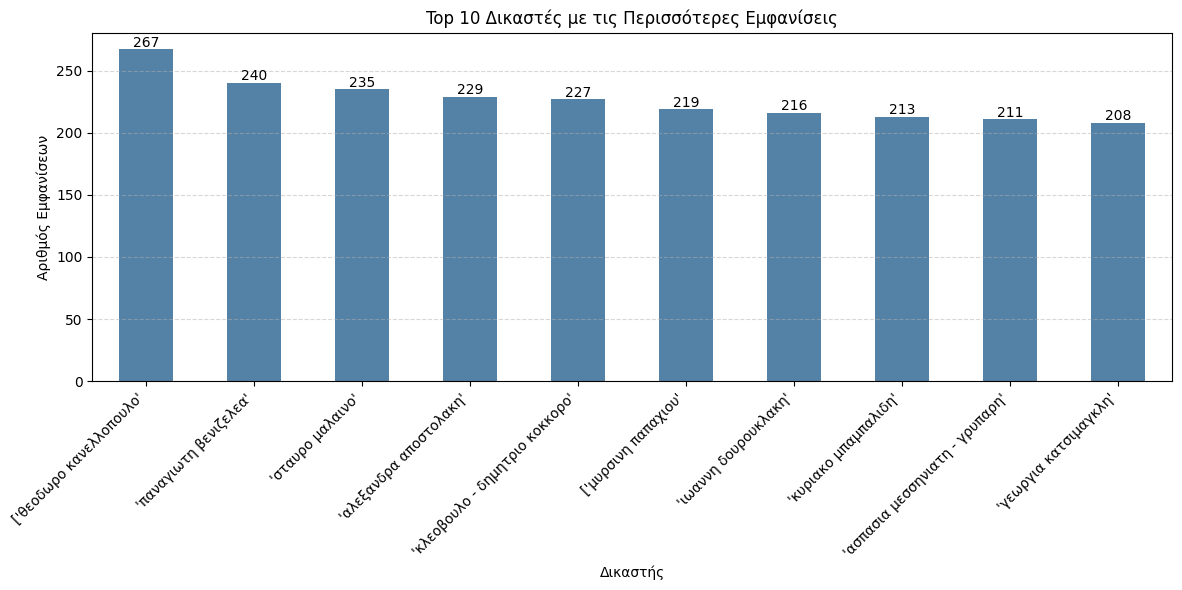

In [21]:
# Count the number of decisions for each department type
all_judges = df['judges'].dropna().str.split(',').sum()
all_judges_clean = [j.strip() for j in all_judges if j.strip()]
judge_counts = Counter(all_judges_clean)
top_judges = judge_counts.most_common(10)

df_top_judges = pd.DataFrame(top_judges, columns=['Δικαστής', 'Αριθμός Εμφανίσεων'])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_judges, x='Δικαστής', y='Αριθμός Εμφανίσεων', color='steelblue', width=0.5)

plt.title('Top 10 Δικαστές με τις Περισσότερες Εμφανίσεις')
plt.xlabel('Δικαστής')
plt.ylabel('Αριθμός Εμφανίσεων')
plt.xticks(rotation=45, ha='right')

for i, row in df_top_judges.iterrows():
    plt.text(i, row['Αριθμός Εμφανίσεων'] + 2, str(row['Αριθμός Εμφανίσεων']), ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Αιτιολόγηση:** Για την οπτική παρουσίαση της σχέσης μεταξύ των δικαστών και των τμημάτων του Αρείου Πάγου, επιλέχθηκε η κατασκευή heatmaps, τα οποία αποτυπώνουν τη συχνότητα εμφάνισης των πιο δραστήριων δικαστών ανά τύπο και αριθμό τμήματος.

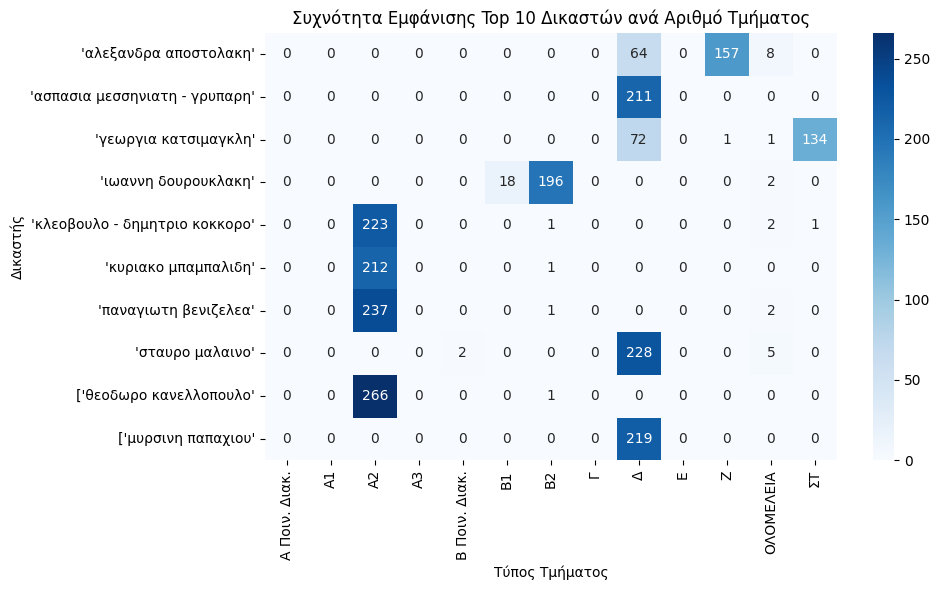

In [22]:
# split the judges column and explode it
df_exploded = df.dropna(subset=['judges']).copy()
df_exploded['judges'] = df_exploded['judges'].str.split(',')
df_exploded = df_exploded.explode('judges')
df_exploded['judges'] = df_exploded['judges'].str.strip()

# Count the top 10 judges
top_judges_list = [j for j, _ in Counter(df_exploded['judges']).most_common(10)]

df_top = df_exploded[df_exploded['judges'].isin(top_judges_list)]

# create a list of all department numbers
all_departments = sorted(df_exploded['department_number'].dropna().unique())


heatmap_data = df_top.pivot_table(
    index='judges',
    columns='department_number',
    aggfunc='size',
    fill_value=0
).reindex(columns=all_departments, fill_value=0)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
plt.title("Συχνότητα Εμφάνισης Top 10 Δικαστών ανά Αριθμό Τμήματος")
plt.xlabel("Τύπος Τμήματος")
plt.ylabel("Δικαστής")
plt.tight_layout()
plt.show()


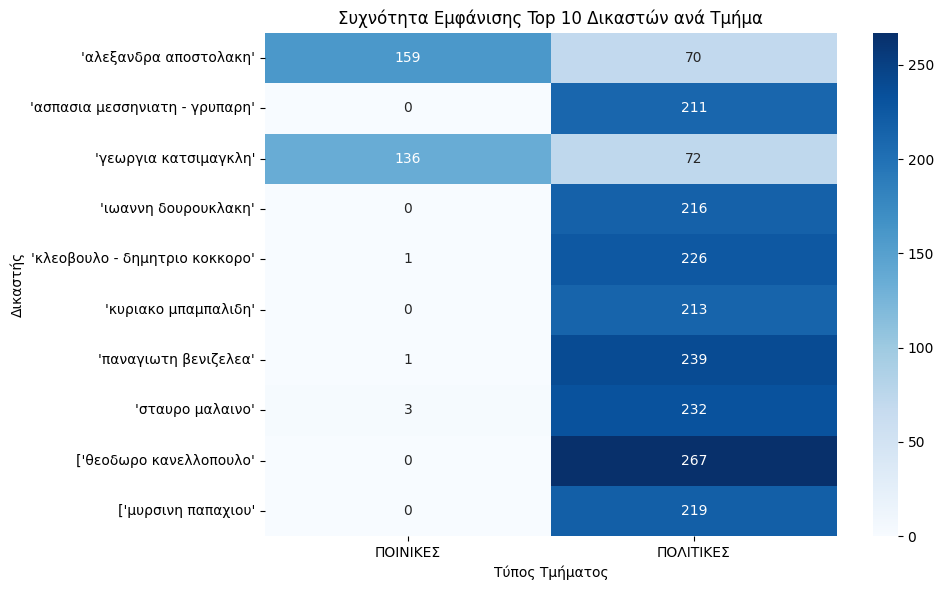

In [24]:

df_exploded = df.dropna(subset=['judges']).copy()
df_exploded['judges'] = df_exploded['judges'].str.split(',')
df_exploded = df_exploded.explode('judges')
df_exploded['judges'] = df_exploded['judges'].str.strip()

top_judges_list = [j for j, _ in Counter(df_exploded['judges']).most_common(10)]

df_top = df_exploded[df_exploded['judges'].isin(top_judges_list)]

heatmap_data = df_top.pivot_table(index='judges', columns='department_type', aggfunc='size', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
plt.title("Συχνότητα Εμφάνισης Top 10 Δικαστών ανά Τμήμα")
plt.xlabel("Τύπος Τμήματος")
plt.ylabel("Δικαστής")
plt.tight_layout()
plt.show()


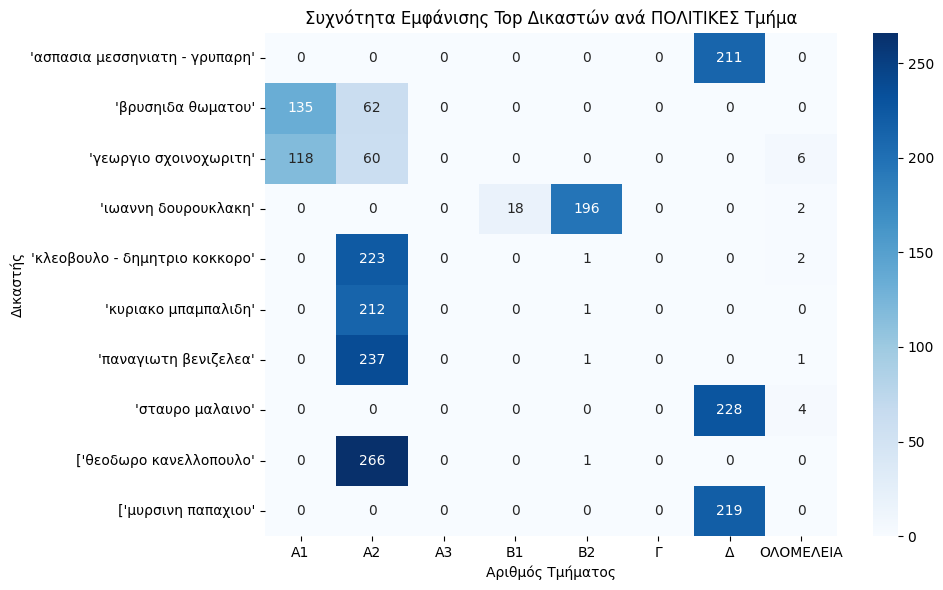

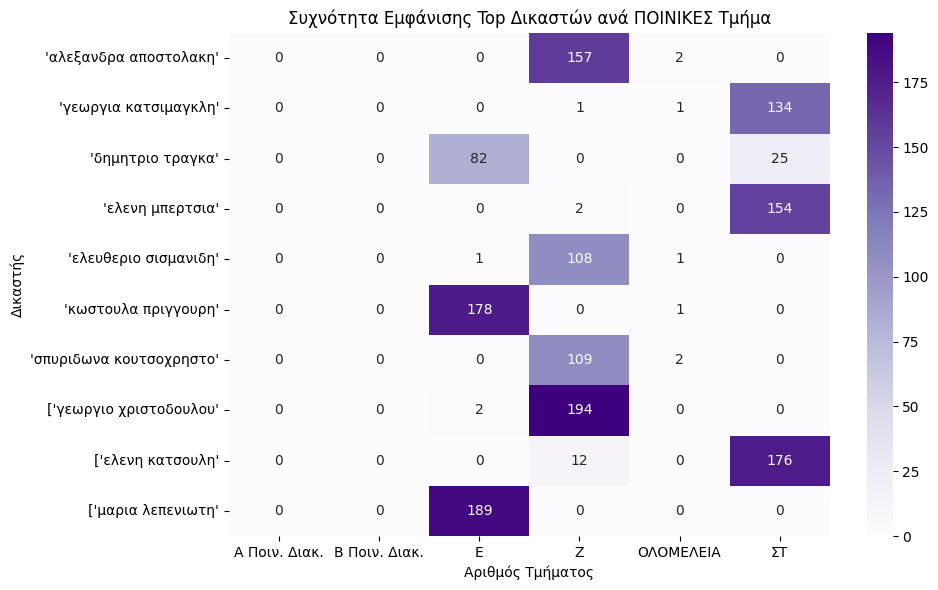

In [25]:
def plot_heatmap_for_type(df, type_name, cmap="Blues"):
    # Φιλτράρισμα μόνο για τον συγκεκριμένο τύπο
    df_type = df[df['department_type'] == type_name].copy()

    # Διάσπαση και καθαρισμός
    df_type['judges'] = df_type['judges'].dropna().str.split(',')
    df_type = df_type.explode('judges')
    df_type['judges'] = df_type['judges'].str.strip()

    # Top 10 δικαστές
    top_judges = [j for j, _ in Counter(df_type['judges']).most_common(10)]

    # Φιλτράρισμα
    df_top = df_type[df_type['judges'].isin(top_judges)]

    # Όλες οι κατηγορίες του department_number για αυτόν τον τύπο
    all_departments = sorted(df_type['department_number'].dropna().unique())

    # Pivot table + reindex
    heatmap_data = df_top.pivot_table(
        index='judges',
        columns='department_number',
        aggfunc='size',
        fill_value=0
    ).reindex(columns=all_departments, fill_value=0)

    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap=cmap)
    plt.title(f"Συχνότητα Εμφάνισης Top Δικαστών ανά {type_name} Τμήμα")
    plt.xlabel("Αριθμός Τμήματος")
    plt.ylabel("Δικαστής")
    plt.tight_layout()
    plt.show()

# Πολιτικά
plot_heatmap_for_type(df, "ΠΟΛΙΤΙΚΕΣ", cmap="Blues")

# Ποινικά
plot_heatmap_for_type(df, "ΠΟΙΝΙΚΕΣ", cmap="Purples")


### Intro_text

**Αιτιολόγιση:** Το συγκεκριμένο γράφημα δημιουργήθηκε με σκοπό να αναδείξει τις συχνότερες λέξεις που χρησιμοποιούνται στο εισαγωγικό κείμενο των αποφάσεων του Αρείου Πάγου, το οποίο συνήθως περιλαμβάνει τυπικές φράσεις, νομικούς όρους και σταθερές εκφράσεις.

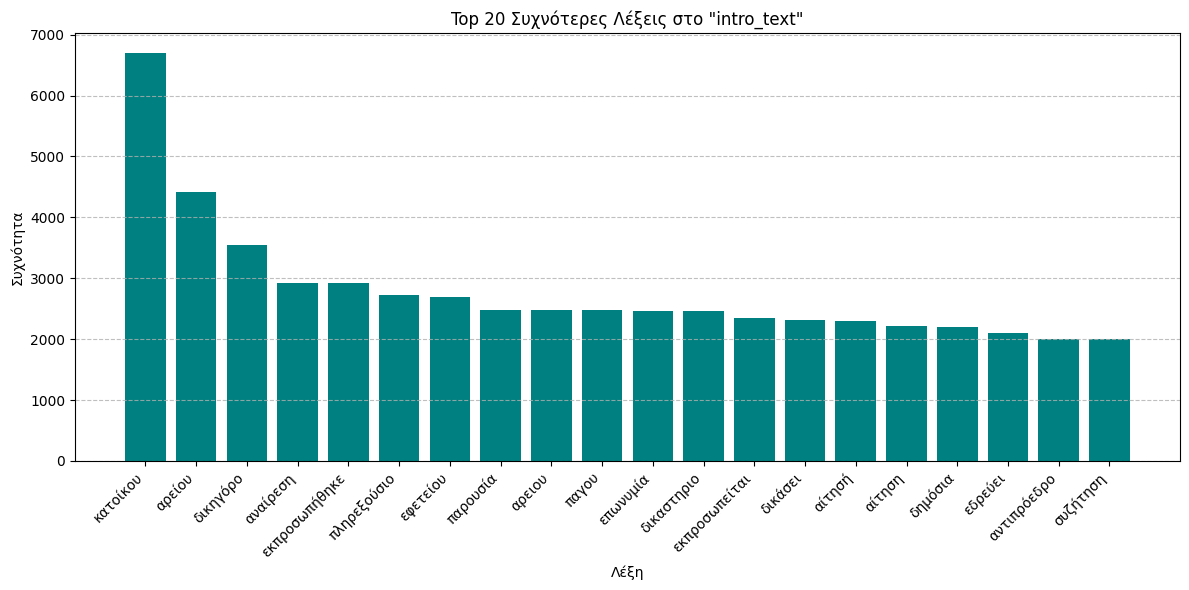

In [26]:
# list of stopwords
greek_stopwords = set([
    'το', 'του','τους', 'της', 'και', 'με', 'στο', 'στη', 'στην', 'στις', 'των',
    'σε', 'από', 'ως', 'ή', 'ότι', 'για', 'η', 'οι', 'τα', 'θα', 'είναι', 'να',
    'δεν', 'έχει', 'ήταν', 'ο', 'την', 'τον', 'προς', 'κατά', 'επί', 'αν', 'όπως','που','οποιος','οποία','ήδη'
])

text_data = df['intro_text'].dropna().astype(str).str.cat(sep=' ')

# Remove punctuation and convert to lowercase
words = [
    word.strip('.,;:!?«»"ʼ΄’‘()[]{}').lower()
    for word in text_data.split()
    if word.isalpha() and len(word) > 2 and word.lower() not in greek_stopwords
]

word_freq = Counter(words)
top_words = word_freq.most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['Λέξη', 'Συχνότητα'])


plt.figure(figsize=(12, 6))
plt.bar(top_words_df['Λέξη'], top_words_df['Συχνότητα'], color='teal')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Συχνότερες Λέξεις στο "intro_text"')
plt.xlabel('Λέξη')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)
plt.tight_layout()
plt.show()

### Legal_reasoning

**Αιτιολόγιση:** Το συγκεκριμένο γράφημα δημιουργήθηκε με σκοπό να αναδείξει τις συχνότερες λέξεις που χρησιμοποιούνται στο νομικό σκεπτικό των αποφάσεων του Αρείου Πάγου, το οποίο  αναδεικνύει τον πυρήνα της νομικής τεκμηρίωσης που ακολουθείται σε κάθε υπόθεση

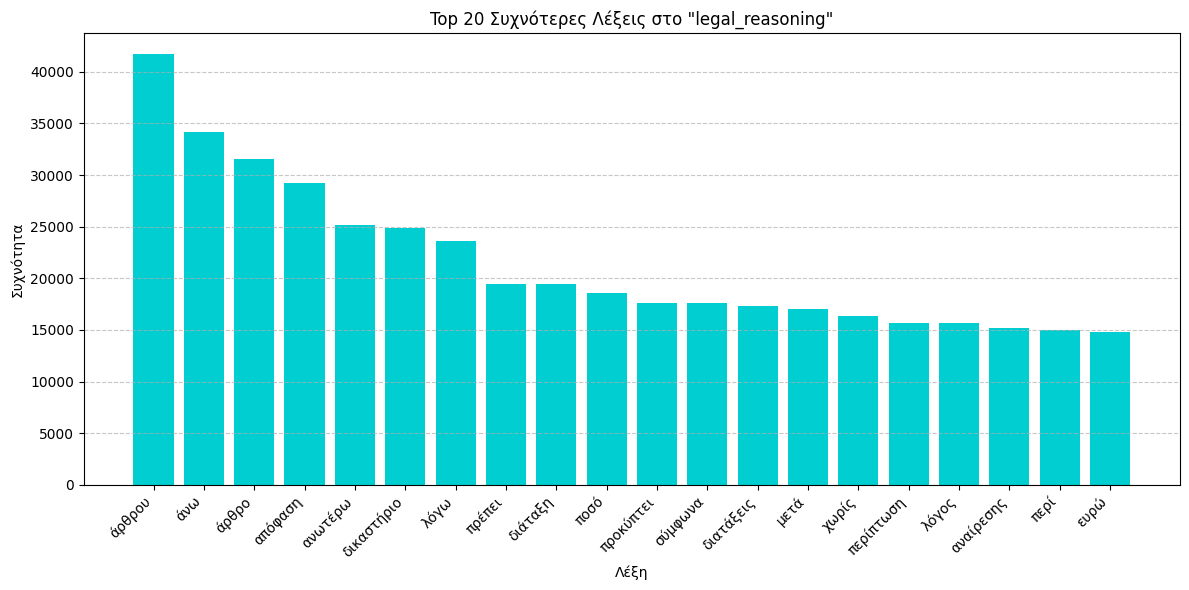

In [27]:
# Stopwords
greek_stopwords = set([
    'το', 'του','τους', 'της', 'και', 'με', 'στο', 'στη', 'στην', 'στις', 'των','τις','στον','αυτή','οποίο','είχε',
    'σε', 'από', 'ως', 'ή', 'ότι', 'για', 'η', 'οι', 'τα', 'θα', 'είναι', 'να','όταν','αλλά','όμως','στα','αυτό','ενώ',
    'δεν', 'έχει', 'ήταν', 'ο', 'την', 'τον', 'προς', 'κατά', 'επί', 'αν', 'όπως','που','οποιος','οποία','ήδη'
])

# cleaning the text data
text_data = df['legal_reasoning'].dropna().astype(str).str.cat(sep=' ')
words = [
    word.strip('.,;:!?«»"ʼ΄’‘()[]{}').lower()
    for word in text_data.split()
    if word.isalpha() and len(word) > 2 and word.lower() not in greek_stopwords
]

# Count word frequencies
word_freq = Counter(words)
top_words = word_freq.most_common(20)

top_words_df = pd.DataFrame(top_words, columns=['Λέξη', 'Συχνότητα'])

plt.figure(figsize=(12, 6))
plt.bar(top_words_df['Λέξη'], top_words_df['Συχνότητα'], color='darkturquoise')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Συχνότερες Λέξεις στο "legal_reasoning"')
plt.xlabel('Λέξη')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.7)
plt.tight_layout()
plt.show()


### Decision_basis

**Αιτιολόγιση:** Το πεδίο decision_basis περιλαμβάνει τα σημεία της αιτιολογίας που σχετίζονται με το τελικό νομικό συμπέρασμα ή τη βάση λήψης της απόφασης. Η ανάλυση συχνοτήτων λέξεων εδώ αποκαλύπτει ποιοι νομικοί όροι και εκφράσεις χρησιμοποιούνται συστηματικά για να λήψη μιας απόφασης.

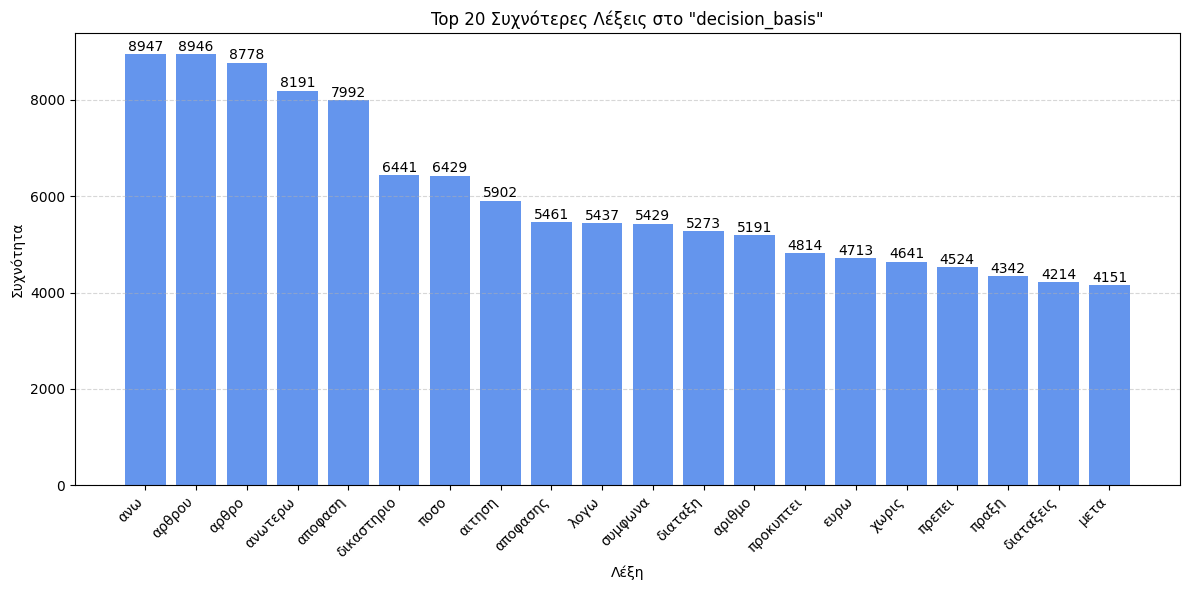

In [28]:
# Stopwords 
greek_stopwords = set([
    'το', 'του','τους', 'της', 'και', 'με', 'στο', 'στη', 'στην', 'στις', 'των','τις','στον','αυτη','οποιο','ειχε',
    'σε', 'απο', 'ως', 'οτι', 'για', 'η', 'οι', 'τα', 'θα', 'ειναι', 'να','οταν','αλλα','ομως','στα','αφου','ενω',
    'δεν', 'εχει', 'ηταν', 'ο', 'την', 'τον', 'προς', 'κατα', 'επι', 'αν', 'οπως','που','οποιος','οποια','ηδη'
])

text_data = df['decision_basis'].dropna().astype(str).str.cat(sep=' ')

words = [
    word.strip('.,;:!?«»"ʼ΄’‘()[]{}').lower()
    for word in text_data.split()
    if word.isalpha() and len(word) > 2 and word.lower() not in greek_stopwords
]


word_freq = Counter(words)
top_words = word_freq.most_common(20)

top_words_df = pd.DataFrame(top_words, columns=['Λέξη', 'Συχνότητα'])

plt.figure(figsize=(12, 6))
plt.bar(top_words_df['Λέξη'], top_words_df['Συχνότητα'], color='cornflowerblue')
plt.title('Top 20 Συχνότερες Λέξεις στο "decision_basis"')
plt.xlabel('Λέξη')
plt.ylabel('Συχνότητα')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, val in enumerate(top_words_df['Συχνότητα']):
    plt.text(i, val + 10, str(val), ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Αιτιολόγιση:** Αυτό το γράφημα συνοψίζει τις αποφάσεις σε κατηγορίες έκβασης (π.χ. Απόρριψη, Αποδοχή, Μερική Αποδοχή). Ο στόχος είναι να εντοπιστεί η ποσοτική κατανομή των τύπων αποφάσεων σε όλο το dataset.

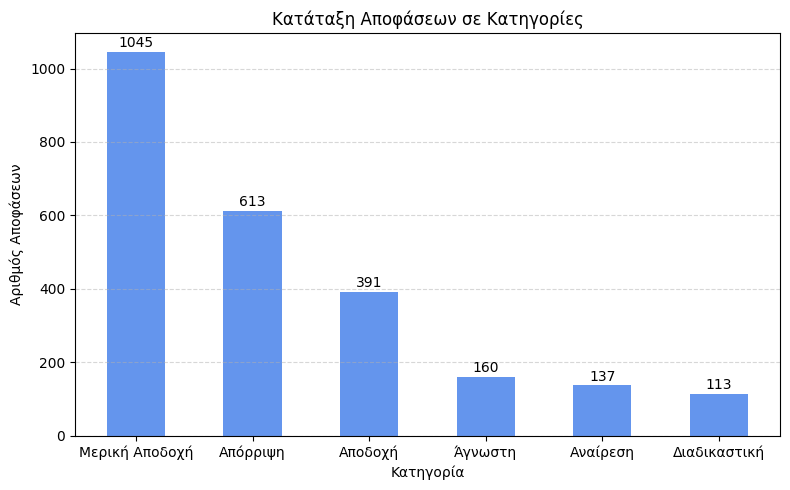

In [29]:
def classify_decision(text):
    if pd.isna(text):
        return 'Άγνωστη'

    text = text.lower()
    
    has_accept = any(word in text for word in ['δεχεται', 'υποχρεωνει', 'καταδικαζει'])
    has_reject = any(word in text for word in ['απορριπτει', 'απαραδεκτη'])
    has_annul = 'αναιρει' in text
    has_refer = 'παραπεμπει' in text

    is_procedural = any(word in text for word in [
        'επαναληψη', 'διορθωνει', 'συμπληρωνει', 'αναβαλλει', 'κηρυσσει', 'αποφαινεται', 'συνεκδικαζει', 'διορθωση', 'καταργει'
    ])

    if has_accept and has_reject:
        return 'Μερική Αποδοχή'
    elif has_annul and has_refer and not has_accept and not has_reject:
        return 'Αναίρεση'
    elif has_accept:
        return 'Αποδοχή'
    elif has_reject:
        return 'Απόρριψη'
    elif is_procedural:
        return 'Διαδικαστική'
    else:
        return 'Άγνωστη'


df['decision_category'] = df['decision_basis'].apply(classify_decision)


category_counts = df['decision_category'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(category_counts.index, category_counts.values, color='cornflowerblue', width=0.5)
plt.title('Κατάταξη Αποφάσεων σε Κατηγορίες')
plt.xlabel('Κατηγορία')
plt.ylabel('Αριθμός Αποφάσεων')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, val in enumerate(category_counts.values):
    plt.text(i, val + 5, str(val), ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Articles

**Αιτιολόγιση:** Η συγκεκριμένη σύνθεση 4 διαγραμμάτων απεικονίζει τα 10 συχνότερα άρθρα που αναφέρονται στις αποφάσεις του Αρείου Πάγου για κάθε ένα από τους βασικούς νομικούς κώδικες,
Ποινικός Κώδικας (ΠΚ), Κώδικας Ποινικής Δικονομίας (ΚΠΔ), Αστικός Κώδικας (ΑΚ) και Κώδικας Πολιτικής Δικονομίας (ΚΠολΔ).

Ο στόχος είναι να εντοπιστούν ποια άρθρα της κάθε νομοθεσίας χρησιμοποιούνται πιο συχνά, το γεγονός αυτο αποκαλύπτει οτι ορισμένα άρθρα εμφανίζονται διαχρονικά ανεξαρτήτως τύπου υπόθεσης.

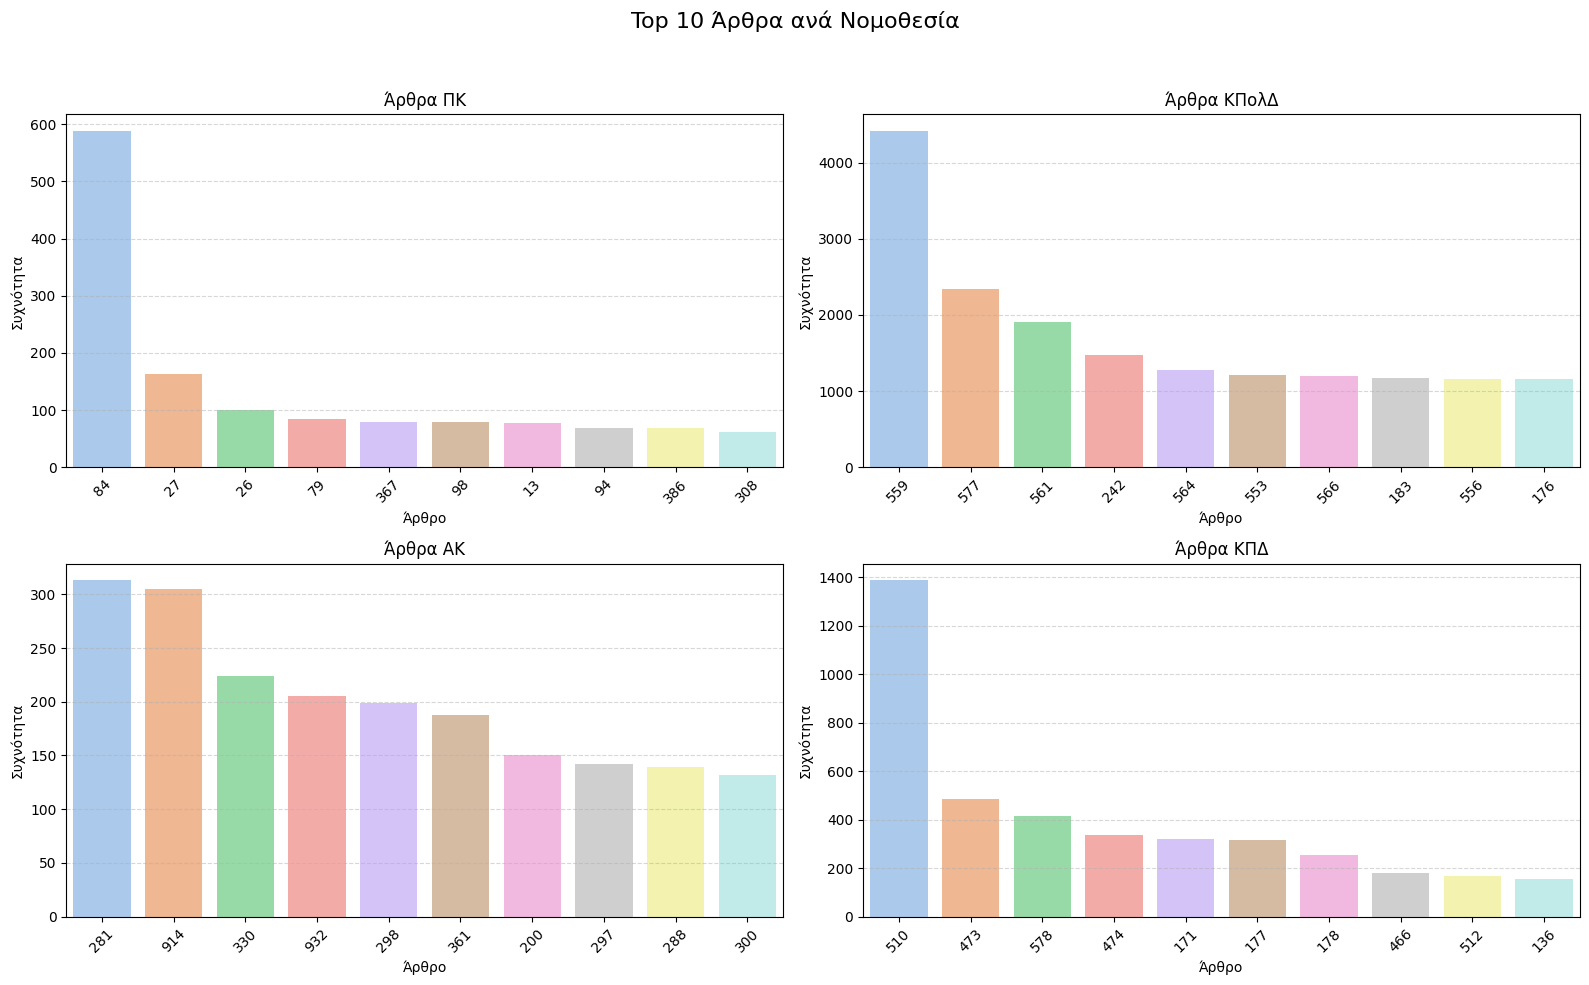

In [30]:
# Function to extract articles from the text
def extract_first_number(text):
    match = re.match(r'\d+', str(text).strip())
    return match.group() if match else None

def process_article_column(series):
    # Drop NaN, convert strings to lists
    parsed = series.dropna().apply(ast.literal_eval)
    flat = parsed.explode()
    numbers = flat.apply(extract_first_number).dropna()
    return Counter(numbers)

# Plotting the top 10 articles for each legislation
columns = ['articles_pk', 'articles_kpold', 'articles_ak', 'articles_kpd']
titles = ['Άρθρα ΠΚ', 'Άρθρα ΚΠολΔ', 'Άρθρα ΑΚ', 'Άρθρα ΚΠΔ']

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Top 10 Άρθρα ανά Νομοθεσία", fontsize=16)

for ax, col, title in zip(axs.flat, columns, titles):
    counts = process_article_column(df[col])
    top_items = counts.most_common(10)
    if not top_items:
        ax.set_title(f"{title} (χωρίς δεδομένα)")
        continue
    articles, frequencies = zip(*top_items)
    sns.barplot(
        x=list(articles),
        y=list(frequencies),
        hue=list(articles),
        ax=ax,
        palette='pastel',
        legend=False
    )
    ax.set_title(title)
    ax.set_xlabel("Άρθρο")
    ax.set_ylabel("Συχνότητα")
    ax.set_xticks(range(len(articles)))
    ax.set_xticklabels(articles, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
